<a href="https://colab.research.google.com/github/ShreyD06/Drought-Shield/blob/main/ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-shreyderdesai')

In [ ]:
pip install pyhdf

In [ ]:
pip install basemap

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from pyhdf.SD import SD, SDC


# Open file.
FILE_NAME = 'MOD13A1.A2000049.mosaic.061.2024048193418.psmcgscs_000502096070.500m_16_days_NDVI.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# List available SDS datasets.
print(hdf.datasets())

DATAFIELD_NAME='500m 16 days NDVI'
data3D = hdf.select(DATAFIELD_NAME)

data = data3D.get()
data

scale_factor = data3D.attributes()['scale_factor']


all_metadata = hdf.attributes()
print(all_metadata)

{'500m 16 days NDVI': (('YDim:MODIS_Grid_16DAY_500m_VI', 'XDim:MODIS_Grid_16DAY_500m_VI'), (360, 766), 22, 0)}


array([[-3000, -3000, -3000, ...,  1964,  1973,  2221],
       [-3000, -3000, -3000, ...,  2488,  2286,  2929],
       [-3000, -3000, -3000, ...,  2286,  2929,  3568],
       ...,
       [ 6678,  5956,   979, ...,  1444,  2285,  2780],
       [ 5976,  4920,  5125, ...,  2530,  2728,  3216],
       [ 3191,  5125,  1897, ...,  2728,  2728,  3077]], dtype=int16)

In [ ]:
lst = ee.ImageCollection('MODIS/061/MOD11A2')

ndvi = ee.ImageCollection('MODIS/061/MOD13A2')

et = ee.ImageCollection('MODIS/061/MOD16A2GF')

# Initial date of interest (inclusive).
i_date = '2000-02-24'

# Final date of interest (exclusive).
f_date = '2023-11-18'

# Selection of appropriate bands and dates for LST.
# lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)
lst = lst.select('LST_Day_1km').filterDate(i_date, f_date)
ndvi = ndvi.select('NDVI').filterDate(i_date, f_date)
et = et.select('ET').filterDate(i_date, f_date)

In [ ]:
et = ee.ImageCollection('MODIS/061/MOD16A2GF')
pet = et.select('PET').filterDate(i_date, f_date)

In [ ]:
roi = ee.Geometry.Rectangle([-122, 39.5, -120.5, 41])

In [ ]:
import geemap
import numpy as np

lst_img = lst.first()

img = geemap.ee_to_numpy(lst_img, region=roi)
print(img.shape)

ndvi_img = ndvi.first()
img = geemap.ee_to_numpy(ndvi_img, region=roi)
print(img.shape)

et_img = et.first()
img = geemap.ee_to_numpy(et_img, region=roi, scale=ndvi_img.projection().nominalScale())
print(img.shape)

(181, 384, 1)
(181, 384, 1)
(181, 384, 1)


In [ ]:
spei = ee.ImageCollection("GRIDMET/DROUGHT")
spei = spei.select('spei180d').filterDate(i_date, f_date)
spei_img = spei.first()

In [ ]:
spei_img.projection()

In [ ]:
resampled = spei_img.resample('bicubic')
resampled = resampled.reproject(ndvi_img.projection())

In [ ]:
import geemap
import numpy as np
spei_arr = geemap.ee_to_numpy(resampled, region=roi)

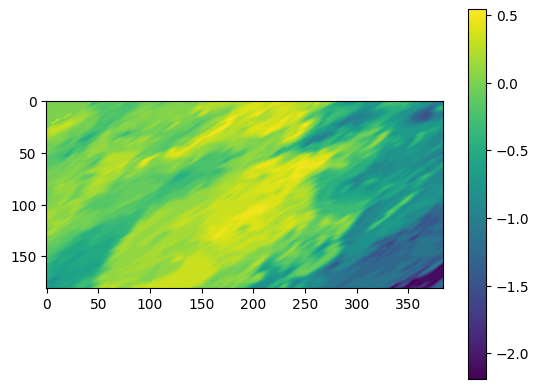

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(spei_arr, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar()  # Add a colorbar to show the scale
plt.show()

In [ ]:
ndvi_arr = np.zeros(shape=(546, 181, 384, 1))
ndvi_list = ndvi.toList(ndvi.size())

for i in range(546):
  ndvi_img = geemap.ee_to_numpy(ee.Image(ndvi_list.get(i)), region=roi)
  ndvi_arr[i] = ndvi_img


In [ ]:
lst_data = np.zeros(shape=(546, 181, 384, 1))
lst_list = lst.toList(lst.size())

for i in range(546):
  if i >= 30:
    lst_img = geemap.ee_to_numpy(ee.Image(lst_list.get(2*i)), region=roi)
  else:
    lst_img = geemap.ee_to_numpy(ee.Image(lst_list.get(2*i+1)), region=roi)

  lst_data[i] = lst_img


In [ ]:
et_arr = np.zeros(shape=(546, 181, 384, 1))
et_list = et.toList(et.size())

for i in range(546):
  et_img = geemap.ee_to_numpy(ee.Image(et_list.get(2*i)), region=roi, scale=ndvi.first().projection().nominalScale())
  et_arr[i] = et_img


In [ ]:
pet_arr = np.zeros(shape=(546, 181, 384, 1))
pet_list = pet.toList(pet.size())

for i in range(546):
  pet_img = geemap.ee_to_numpy(ee.Image(pet_list.get(2*i)), region=roi, scale=ndvi.first().projection().nominalScale())
  pet_arr[i] = pet_img


In [ ]:
ndvi_data = ndvi_arr.reshape((546, 181, 384))

In [ ]:
lst_data = lst_data.reshape((546, 181, 384))
lst_data.shape

(546, 181, 384)

In [ ]:
et_data = et_arr.reshape((546, 181, 384))

In [ ]:
pet_data = pet_arr.reshape((546, 181, 384))

In [ ]:
for i in et_data:
  counts = []
  for n in range(32761, 32768):
    counts.append(np.count_nonzero(i == n))
  print(counts)

[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]
[4515, 0, 0, 0, 0, 0, 0]


Checkpoint: Indices/dates to be removed: 367, 520, 545

In [ ]:
for i, ndvi_i in enumerate(ndvi_data):
  # Identify indices of elements equal to -3000
  nan_indices = np.where(ndvi_i == -3000)
  # Replace -3000 with NaN
  ndvi_i[nan_indices] = np.nan

  ndvi_data[i] = ndvi_i

In [ ]:
for i, lst_i in enumerate(lst_data):
  # Identify indices of elements equal to -3000
  nan_indices = np.where(lst_i == 0)
  # Replace -3000 with NaN
  lst_i[nan_indices] = np.nan

  lst_data[i] = lst_i

In [ ]:
for i in range(lst_data.shape[0]):
  if np.sum(np.isnan(lst_data[i]))/(181*384) > 0.1:
    print(np.sum(np.isnan(lst_data[i]))/(181*384), i)

In [ ]:
for i, img in enumerate(ndvi_data):
  ndvi_data[i] = np.nan_to_num(img, nan=np.nanmean(img))

In [ ]:
for i in range(ndvi_data.shape[0]):
  print(np.sum(np.isnan(ndvi_data[i]))/(181*384))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
for i, img in enumerate(lst_data):
  lst_data[i] = np.nan_to_num(img, nan=np.nanmean(img))

<ipython-input-18-63a58c9d0cab>:2: RuntimeWarning: Mean of empty slice
  lst_data[i] = np.nan_to_num(img, nan=np.nanmean(img))


In [ ]:
ndvi_data = np.delete(ndvi_data, (367, 520, 545), axis=0)
lst_data = np.delete(lst_data, (367, 520, 545), axis=0)
et_data = np.delete(et_data, (367, 520, 545), axis=0)

In [ ]:
pet_data = np.delete(pet_data, (367, 520, 545), axis=0)

In [ ]:
edi_data = np.zeros(shape=et_data.shape)
for i in range(et_data.shape[0]):
  edi_data[i] = np.subtract(np.ones(shape=et_data[0].shape), np.divide(et_data[i], pet_data[i]))


In [ ]:
lst_img = lst.first().clip(roi)

lst_val = lst_img.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=lst_img.geometry(),
    scale=lst_img.projection().nominalScale()
)

lst_val = lst_val.get('LST_Day_1km')
lst_list = lst_val.getInfo()
print(lst_list)


# roi = ee.Geometry.Rectangle([-122, 39.5, -121, 41])

# lst_img = lst.first().clip(roi)

# lst_val = lst_img.reduceRegion(
#     reducer=ee.Reducer.toList(),
#     geometry=lst_img.geometry(),
#     scale=lst_img.projection().nominalScale()
# )

# lst_val = lst_val.get('LST_Day_1km')
# lst_list2 = lst_val.getInfo()
# print(lst_list2)


[14189, 14221, 14276, 14326, 14328, 14268, 14234, 14232, 14237, 14259, 14265, 14264, 14269, 14270, 14252, 14182, 13964, 13856, 13817, 13835, 13941, 14100, 14217, 14228, 14200, 14213, 14220, 14189, 14201, 14170, 14184, 14112, 14154, 14178, 14191, 14447, 14456, 14425, 14391, 14383, 14421, 14508, 14493, 14498, 14506, 14523, 14520, 14475, 14438, 14448, 14476, 14513, 14457, 14406, 14378, 14372, 14376, 14386, 14042, 14057, 14479, 14175, 14192, 14204, 14189, 14276, 14451, 14425, 14390, 14366, 14383, 14283, 14257, 14255, 14276, 14381, 14395, 14065, 14044, 14072, 14029, 13906, 13787, 13685, 13861, 13883, 13873, 13913, 14000, 13965, 13892, 13879, 14114, 14112, 14138, 14065, 14062, 14130, 14030, 14029, 14129, 14120, 14129, 14109, 14123, 14069, 13979, 13926, 14030, 14093, 14073, 13772, 13837, 13782, 13752, 13738, 13753, 13788, 13819, 13856, 13951, 14194, 14118, 14137, 13933, 14008, 13915, 13854, 13876, 14029, 14250, 14153, 14243, 14261, 14258, 14299, 14227, 14251, 14327, 14290, 14228, 14217, 14202

In [ ]:
len(lst_list)

24027

In [ ]:
roi = ee.Geometry.Rectangle([-122, 39.5, -120.5, 41])

ndvi_img = ndvi.first().clip(roi)

ndvi_val = ndvi_img.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=ndvi_img.geometry(),
    scale=ndvi_img.projection().nominalScale()
)

ndvi_val = ndvi_val.get('NDVI')
ndvi_list = ndvi_val.getInfo()
print(ndvi_list)


roi = ee.Geometry.Rectangle([-122, 39.5, -121, 41])

ndvi_img = ndvi.first().clip(roi)

ndvi_val = ndvi_img.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=ndvi_img.geometry(),
    scale=ndvi_img.projection().nominalScale()
)

ndvi_val = ndvi_val.get('NDVI')
ndvi_list2 = ndvi_val.getInfo()
print(ndvi_list2)


[7504, 7543, 6487, 6475, 6375, 6345, 7450, 7429, 7230, 7320, 6342, 6835, 7121, 8120, 7840, 5425, 1059, 429, 3424, 6438, 7460, 6957, 6796, 6116, 6238, 7201, 7209, 6644, 6965, 5566, 5505, 5528, 5768, 4936, 4052, 4756, 5006, 4598, 3344, 3644, 4178, 4443, 3895, 3970, 4031, 3817, 3465, 4156, 4045, 4400, 5000, 4182, 4428, 4187, 3981, 3985, 3854, 3912, 4245, 4305, 4332, 4753, 5126, 4066, 3462, 3897, 4442, 3657, 3803, 3879, 4425, 5260, 4644, 2040, 2928, 2860, 2375, 3068, 3007, 3241, 5820, 6750, 5973, 5819, 5466, 4717, 4126, 4849, 4889, 4797, 4828, 4860, 4842, 4729, 4187, 4035, 3406, 4745, 3133, 2912, 3191, 1792, 2887, 3239, 4284, 4223, 4223, 5424, 5580, 4874, 4501, 1353, 392, -110, -104, 1380, 539, 142, 184, 411, 1104, 703, 471, 3759, 33, -549, -447, -417, 1516, 1738, 2149, 2257, 2040, 2088, 1915, 2206, 7864, 7068, 7185, 7097, 7501, 7772, 7867, 7474, 7391, 7887, 6761, 7237, 7348, 5593, 7780, 7708, 2961, 6870, 7518, 7386, 7440, 6843, 7448, 7409, 7215, 7154, 6748, 6011, 5291, 5215, 5126, 5520, 5

In [ ]:
len(ndvi_list)

24706

In [ ]:
import pandas as pd
import numpy as np
u_lon = -116.5
u_lat = 33
u_poi = ee.Geometry.Point(u_lon, u_lat)
ndvi_data = np.zeros(shape=(546, 121, 4))
lst_data = np.zeros(shape=(546, 121))


#They have 1 more timestep than et because of the bad index 502 timestep

In [ ]:


point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    u_poi = ee.Geometry.Point(-116.5+(lon*0.15), 33+(lat*0.15))
    arr = np.array(ndvi.getRegion(u_poi, 500).getInfo())
    point += 1
    for i in range(1, 547):
      ndvi_data[i-1][point-1] = arr[i][1:5]




NameError: name 'np' is not defined

In [ ]:
ndvi_data = np.delete(ndvi_data, (456, 457), axis=0)
ndvi_data.shape

(544, 121, 4)

In [ ]:
import pandas as pd
import numpy as np
u_lon = -122
u_lat = 39.5
u_poi = ee.Geometry.Point(u_lon, u_lat)
ndvi_data = np.zeros(shape=(546, 121, 4))
lst_data = np.zeros(shape=(546, 121))
#They have 1 more timestep than et because of the bad index 502 timestep

In [ ]:
point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
    arr = np.array(ndvi.getRegion(u_poi, 500).getInfo())
    point += 1
    for i in range(1, 547):
      ndvi_data[i-1][point-1] = arr[i][1:5]

In [ ]:
# print(ndvi_data[0][16])


# for i in range(len(ndvi_data)):
#   print(sum(np.isnan(ndvi_data[i,:,3])))
np.sum(np.isnan(ndvi_data[:,:,3]), axis=1)

array([0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1,
       0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1,
       2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,

In [ ]:
ndvi_data_cleaned = np.zeros(shape = (544, 121))
for i, ndvis in enumerate(ndvi_data):
  df = pd.DataFrame(ndvis[:, 3])
  ndvi_data_cleaned[i] = df.interpolate().to_numpy().reshape((121,))

In [ ]:
ndvi_data_cleaned *= 0.0001

In [ ]:
ndvi_means = np.nanmean(ndvi_data[:, :, 3], axis=1)
ndvi_means = ndvi_means*0.0001
len(ndvi_means)

544

In [ ]:
point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
        u_poi = ee.Geometry.Point(-116.5+(lon*0.15), 33+(lat*0.15))
        arr2 = np.array(lst.getRegion(u_poi, 1000).getInfo())
        point += 1
        for i in range(1, 547):
          if i >= 31:
            lst_data[i-1][point-1] = arr2[2*i-2][4]
          else:
            lst_data[i-1][point-1] = arr2[(2*i)-1][4]


In [ ]:
point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
        u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
        arr2 = np.array(lst.getRegion(u_poi, 1000).getInfo())
        point += 1
        for i in range(1, 547):
          if i >= 31:
            lst_data[i-1][point-1] = arr2[2*i-2][4]
          else:
            lst_data[i-1][point-1] = arr2[(2*i)-1][4]


In [ ]:
u_poi = ee.Geometry.Point(-122, 39.5)
arr = np.array(lst.getRegion(u_poi, 1000).getInfo())[1:, 0]
arr2 = np.array(ndvi.getRegion(u_poi, 500).getInfo())[1:, 0]

In [ ]:
lst_data = np.delete(lst_data, (456, 457), axis=0)
lst_data.shape

(544, 121)

In [ ]:
np.sum(np.isnan(lst_data), axis=1)

array([ 2,  0,  0,  7,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0, 19,
        0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  4, 44,  2, 84,  0,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 66, 76, 18, 31,
        0,  0,  1,  0,  2, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  2, 27,  7,  2,  0, 24,  0,  0, 55,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  8,  0,  0, 37,  3,  0,  4,  0,  1,  0,  0,
       43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  3, 95,  1,
       81,  0, 31, 27, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  7,  0, 52,  0,  0,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 57,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 29

In [ ]:
nlst_data = np.zeros(shape = (544, 121))
for i, lsts in enumerate(lst_data):
  df = pd.DataFrame(lsts)
  nlst_data[i] = df.interpolate().to_numpy().reshape((121,))

In [ ]:
nlst_data *= 0.02

In [ ]:
np.sum(np.isnan(nlst_data), axis=1)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
lst_mean_per_timestep = np.nanmean(nlst_data, axis=1)

# Iterate over each remaining timestep
for i in range(len(lst_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(nlst_data[i])

    val = int(round(lst_mean_per_timestep[i]))
    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    nlst_data[i, nan_mask] = val

In [ ]:
lst_means = np.nanmean(nlst_data[:, :], axis=1)
lst_means = lst_means*0.02
len(lst_means)

544

In [ ]:

lst_u_poi = lst.getRegion(u_poi, 1000).getInfo()
ndvi_u_poi = ndvi.getRegion(u_poi, 500).getInfo()
# arr = np.array(ndvi_u_poi)

# print(arr.shape)
# print(arr[1])
df = pd.DataFrame(lst_u_poi)

df2 = pd.DataFrame(ndvi_u_poi)
df2
# headers = df.iloc[0]
# df = pd.DataFrame(df.values[2:], columns=headers)


# headers = df2.iloc[0]
# df2 = pd.DataFrame(df2.values[1:], columns=headers)
# df


# df = pd.DataFrame(otherndvi)
# df

# print(df.shape)
# print(df['id'][58], df2['id'][29])
# for i in range(0, 546):
#   if i >= 30:
#     print(df['id'][2*i-1], df2['id'][i])
#   else:
#     print(df['id'][2*i], df2['id'][i])

  # if df['id'][2*i] != df2['id'][i]:
  #   print(df['id'][2*i], df2['id'][i], i)
#CONCLUSION: At 30, switch from being 2i to 2i-1

# df = df.dropna()

# print(df.shape)

# df

,0,1,2,3,4,5
0,id,longitude,latitude,time,NDVI,DetailedQA
1,2000_03_05,-116.500263,33.001858,952214400000,4265,2116
2,2000_03_21,-116.500263,33.001858,953596800000,4211,2116
3,2000_04_06,-116.500263,33.001858,954979200000,4160,2116
4,2000_04_22,-116.500263,33.001858,956361600000,4633,2116
...,...,...,...,...,...,...
542,2023_09_14,-116.500263,33.001858,1694649600000,4391,2116
543,2023_09_30,-116.500263,33.001858,1696032000000,4177,2116
544,2023_10_16,-116.500263,33.001858,1697414400000,4650,2116
545,2023_11_01,-116.500263,33.001858,1698796800000,4560,2116


In [ ]:
et1 = ee.ImageCollection("MODIS/061/MOD16A2GF")
et1 = et1.select("ET", "PET", "ET_QC").filterDate('2022-11-20', '2022-11-26')
chgpoints = []
chgcoords = []

point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
    if et1.getRegion(u_poi, 500).getInfo()[1][4] == None:
      chgpoints.append(point)
      chgcoords.append((lat, lon))
    point += 1

# Conclusion: Add slightly diferrent coordinates for these 3 values

In [ ]:
chgpoints

[3, 23, 61, 85]

In [ ]:
et1 = ee.ImageCollection("MODIS/061/MOD16A2GF")
et1 = et1.select("ET", "PET", "ET_QC").filterDate('2000-03-01', '2023-11-18')
df = pd.DataFrame(et1.getRegion(u_poi, 500).getInfo())
df

,0,1,2,3,4,5,6
0,id,longitude,latitude,time,ET,PET,ET_QC
1,2000_03_05,-120.497766,41.001355,952214400000,109,171,8
2,2000_03_13,-120.497766,41.001355,952905600000,63,320,8
3,2000_03_21,-120.497766,41.001355,953596800000,56,352,0
4,2000_03_29,-120.497766,41.001355,954288000000,29,437,0
...,...,...,...,...,...,...,...
1046,2022_11_25,-120.497766,41.001355,1669334400000,67,140,16
1047,2022_12_03,-120.497766,41.001355,1670025600000,51,53,105
1048,2022_12_11,-120.497766,41.001355,1670716800000,37,39,97
1049,2022_12_19,-120.497766,41.001355,1671408000000,36,39,73


In [ ]:
et1 = ee.ImageCollection("MODIS/061/MOD16A2GF")
et1 = et1.select("ET", "PET", "ET_QC").filterDate('2010-12-20', '2010-12-28')

point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    u_poi = ee.Geometry.Point(-116.5+(lon*0.15), 33+(lat*0.15))
    arr = np.array(et1.getRegion(u_poi, 500).getInfo())
    print(arr[1])


['2010_12_27' '-116.50026340925045' '33.001857750340925' '1293408000000'
 '28' '137' '0']
['2010_12_27' '-116.35204138737073' '33.001857750340925' '1293408000000'
 '27' '157' '0']
['2010_12_27' -116.19932778907041 33.001857750340925 1293408000000 None
 None 157]
['2010_12_27' '-116.05110576719069' '33.001857750340925' '1293408000000'
 '26' '176' '8']
['2010_12_27' -115.89839216889037 33.001857750340925 1293408000000 None
 None 157]
['2010_12_27' -115.75017014701065 33.001857750340925 1293408000000 None
 None 157]
['2010_12_27' '-115.60194812513093' '33.001857750340925' '1293408000000'
 '63' '104' '0']
['2010_12_27' '-115.44923452683061' '33.001857750340925' '1293408000000'
 '21' '177' '16']
['2010_12_27' -115.30101250495089 33.001857750340925 1293408000000 None
 None 157]
['2010_12_27' -115.14829890665057 33.001857750340925 1293408000000 None
 None 157]
['2010_12_27' -115.00007688477085 33.001857750340925 1293408000000 None
 None 157]
['2010_12_27' '-116.50026340925045' '33.15007977222

In [ ]:
# unique_values = df['id'].unique()
# print(unique_values)

chgcoords
print(len(chgcoords))

oc = []
ocpoints = []
point = 0
count = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    if (lat, lon) in chgcoords:
      #Original: +0.1
      u_poi = ee.Geometry.Point(-116.5+(lon*0.15)+0.07, 33+(lat*0.15)+0.05)
      if et1.getRegion(u_poi, 500).getInfo()[1][4] == None:
        oc.append((lat, lon))
        ocpoints.append(point)
        count += 1
    point += 1

print(count)



61
34


In [ ]:
for lat in range(0, 11):
  for lon in range(0, 11):
    if (lat, lon) not in oc and (lat, lon) in chgcoords:
      u_poi = ee.Geometry.Point(-116.5+(lon*0.15)+0.07, 33+(lat*0.15)+0.05)
    else:
      u_poi = ee.Geometry.Point(-116.5+(lon*0.15), 33+(lat*0.15))
    arr = np.array(et1.getRegion(u_poi, 500).getInfo())
    print(arr[1][4])

In [ ]:
et1 = ee.ImageCollection("MODIS/061/MOD16A2GF")
et1 = et1.select("ET", "PET", "ET_QC").filterDate(i_date, '2023-01-01')

et1_data = np.zeros(shape=(525, 121, 2))

# for lat in range(0, 11):
#   for lon in range(0, 11):
#     u_poi = ee.Geometry.Point(-116.5+(lon*0.15), 33+(lat*0.15))
#     arr = np.array(et1.getRegion(u_poi, 500).getInfo())


point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
        u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
        arr3 = np.array(et1.getRegion(u_poi, 500).getInfo())
        point += 1
        for i in range(1, 526):
          et1_data[i-1][point-1] = arr3[(2*i)][4:6]



# df = pd.DataFrame(et1.getRegion(ee.Geometry.Point(-116.5, 33), 500).getInfo())

# headers = df.iloc[0]
# df = pd.DataFrame(df.values[2:], columns=headers)


# ndvi2 = ndvi.select('NDVI', "DetailedQA").filterDate(i_date, '2023-01-01')
# df2 = pd.DataFrame(ndvi2.getRegion(ee.Geometry.Point(-116.5, 33), 500).getInfo())
# headers = df2.iloc[0]
# df2 = pd.DataFrame(df2.values[1:], columns=headers)

# df2




In [ ]:

# arr = np.array(et1.getRegion(u_poi, 500).getInfo())
# print(arr)

print(et1_data[0])
#IF CELL BELOW DOESN'T WORK: In separate cell, get the alternate values by making a new array with points that are not in ocpoints but in chgpoints. Loop through array and get the values for the coordinates there (shape: (point, timesteps, ET + PET))

In [ ]:
mcp = []
point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    if point not in ocpoints and point in chgpoints:
      mcp.append(point)
    point += 1
print(len(mcp))

27


In [ ]:
for point in mcp:

  u_poi = ee.Geometry.Point(-116.5+((point%11)*0.15)+0.07, 33+((point//11)*0.15)+0.05)
  arr = np.array(et1.getRegion(u_poi, 500).getInfo())
  et1_data[:, point] = [arr[x][4:6] for x in range(2, 1051, 2)]

In [ ]:
print(et1_data[0])

In [ ]:
# for time in et1_data:
#   sum = 0
#   for coord in et1_data:
#     if np.isnan(coord[0])
non_empty_mask = ~np.isnan(et1_data[:, :, 0]).all(axis=1)
et_mean_per_timestep = np.nanmean(et1_data[non_empty_mask, :, 0], axis=1)
print(len(et_mean_per_timestep))

for index, m in enumerate(et_mean_per_timestep):
  if np.isnan(m):
    print(index)

525


In [ ]:
et1_data = np.delete(et1_data, (456, 457), axis=0)
#1/19 5:31 - This was run

In [ ]:
print(et1_data.shape)

(523, 121, 2)


In [ ]:
for i in range(len(et_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(et1_data[i, :, 0])

    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    val = round(et_mean_per_timestep[i])
    et1_data[i, nan_mask, 0] = val

In [ ]:
pet_mean_per_timestep = np.nanmean(et1_data[:, :, 1], axis=1)

for i in range(len(pet_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(et1_data[i, :, 1])

    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    val = round(pet_mean_per_timestep[i])
    et1_data[i, nan_mask, 1] = val

In [ ]:
et2 = ee.ImageCollection("MODIS/061/MOD16A2")
et2 = et2.select("ET", "PET", "ET_QC").filterDate('2023-01-01', f_date)

df = pd.DataFrame(et2.getRegion(ee.Geometry.Point(-116.5, 33), 500).getInfo())
df

,0,1,2,3,4,5,6
0,id,longitude,latitude,time,ET,PET,ET_QC
1,2023_01_01,-116.500263,33.001858,1672531200000,59,185,0
2,2023_01_09,-116.500263,33.001858,1673222400000,64,215,16
3,2023_01_17,-116.500263,33.001858,1673913600000,37,288,0
4,2023_01_25,-116.500263,33.001858,1674604800000,50,290,0
5,2023_02_02,-116.500263,33.001858,1675296000000,43,363,0
6,2023_02_10,-116.500263,33.001858,1675987200000,48,288,0
7,2023_02_18,-116.500263,33.001858,1676678400000,63,288,0
8,2023_02_26,-116.500263,33.001858,1677369600000,74,270,0
9,2023_03_06,-116.500263,33.001858,1678060800000,75,335,0


In [ ]:
et2 = ee.ImageCollection("MODIS/061/MOD16A2")
et2 = et2.select("ET", "PET", "ET_QC").filterDate('2023-03-01', '2023-03-07')
chgpoints2 = []
chgcoords2 = []

point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
    if et2.getRegion(u_poi, 500).getInfo()[1][4] == None:
      chgpoints2.append(point)
      chgcoords2.append((lat, lon))
    point += 1

In [ ]:
chgcoords2
print(len(chgcoords2))

oc2 = []
ocpoints2 = []
point = 0
count = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    if (lat, lon) in chgcoords2:
      #Original: +0.1
      u_poi = ee.Geometry.Point(-116.5+(lon*0.15)+0.07, 33+(lat*0.15)+0.05)
      if et2.getRegion(u_poi, 500).getInfo()[1][4] == None:
        oc2.append((lat, lon))
        ocpoints2.append(point)
        count += 1
    point += 1

print(count)

61
34


In [ ]:
midcoords = []
for lat in range(0, 11):
  for lon in range(0, 11):
    if (lat, lon) not in oc2 and (lat, lon) in chgcoords2:
      midcoords.append((lat, lon))
print(len(midcoords))

27


In [ ]:
et2 = ee.ImageCollection("MODIS/061/MOD16A2")
et2 = et2.select("ET", "PET", "ET_QC").filterDate('2023-01-01', f_date)

et2_data = np.zeros(shape=(21, 121, 2))
point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    # For previous area of study:
    # if (lat, lon) in midcoords:
    #   u_poi = ee.Geometry.Point(-116.5+(lon*0.15)+0.07, 33+(lat*0.15)+0.05)
    # else:
    #   u_poi = ee.Geometry.Point(-116.5+(lon*0.15), 33+(lat*0.15))
    u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
    arr4 = np.array(et2.getRegion(u_poi, 500).getInfo())
    point += 1
    for i in range(1, 22):
      et2_data[i-1][point-1] = arr4[(2*i)-1][4:6]

In [ ]:
non_empty_mask = ~np.isnan(et2_data[:, :, 0]).all(axis=1)
print(non_empty_mask)

# Use the mask to filter out empty slices before calculating the mean
# et_mean_per_timestep = np.nanmean(et1_data[non_empty_mask, :, 0], axis=1)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [ ]:
et2_mean_per_timestep = np.nanmean(et2_data[:, :, 0], axis=1)

# Iterate over each remaining timestep
for i in range(len(et2_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(et2_data[i, :, 0])

    val = int(round(et2_mean_per_timestep[i]))
    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    et2_data[i, nan_mask, 0] = val

In [ ]:
pet2_mean_per_timestep = np.nanmean(et2_data[:, :, 1], axis=1)

# Iterate over each remaining timestep
for i in range(len(pet2_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(et2_data[i, :, 1])

    val = int(round(pet2_mean_per_timestep[i]))
    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    et2_data[i, nan_mask, 1] = val

In [ ]:
et_data = np.concatenate((et1_data, et2_data), axis=0)

In [ ]:
print(et_data.shape)
#EDI should be calculated from ET and PET (1 - (ET/PET))
#EDI Used in: https://sci-hub.se/https://doi.org/10.1016/j.jag.2010.09.009

(544, 121, 2)


In [ ]:
new_et_data = np.zeros(shape=(544, 121, 2))
for i, e in enumerate(et_data):
  df = pd.DataFrame(e[:, 0])
  df2 = pd.DataFrame(e[:, 1])
  new_et_data[i, :, 0] = df.interpolate().to_numpy().reshape((121,))
  new_et_data[i, :, 1] = df2.interpolate().to_numpy().reshape((121,))

In [ ]:
newet_mean_per_timestep = np.nanmean(new_et_data[:, :, 0], axis=1)

for i in range(len(newet_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(new_et_data[i, :, 0])

    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    val = round(newet_mean_per_timestep[i])
    new_et_data[i, nan_mask, 0] = val

In [ ]:
newpet_mean_per_timestep = np.nanmean(new_et_data[:, :, 1], axis=1)

for i in range(len(newpet_mean_per_timestep)):
    # Find NaN values in the ET values for the i-th timestep
    nan_mask = np.isnan(new_et_data[i, :, 1])

    # Replace NaN values with the corresponding mean from et_mean_per_timestep
    val = round(newpet_mean_per_timestep[i])
    new_et_data[i, nan_mask, 1] = val

In [ ]:
np.sum(np.isnan(new_et_data[:, :, 0]), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def calc_edi(a):
  return (1 - (a[0]/a[1]))

edi_data = new_et_data
edi_data = np.apply_along_axis(calc_edi, 2, edi_data)
edi_data[0]

array([0.38983051, 0.35326087, 0.34078212, 0.32407407, 0.30344828,
       0.35294118, 0.35820896, 0.36296296, 0.17171717, 0.16190476,
       0.34645669, 0.41666667, 0.31491713, 0.32954545, 0.3081761 ,
       0.3649635 , 0.33802817, 0.30714286, 0.25925926, 0.21008403,
       0.20634921, 0.17948718, 0.34782609, 0.32727273, 0.30769231,
       0.30463576, 0.35036496, 0.21848739, 0.34285714, 0.18918919,
       0.2421875 , 0.47619048, 0.25      , 0.36363636, 0.325     ,
       0.4084507 , 0.28571429, 0.15116279, 0.18627451, 0.19318182,
       0.4057971 , 0.2755102 , 0.25757576, 0.2605042 , 0.32298137,
       0.34415584, 0.34210526, 0.18446602, 0.2605042 , 0.24793388,
       0.35114504, 0.41911765, 0.47712418, 0.53246753, 0.24770642,
       0.3566879 , 0.35582822, 0.43055556, 0.34351145, 0.18348624,
       0.15178571, 0.16444444, 0.17699115, 0.43243243, 0.29078014,
       0.48666667, 0.39864865, 0.38125   , 0.27868852, 0.17647059,
       0.12121212, 0.19827586, 0.19672131, 0.24409449, 0.53797

In [ ]:
edi_means = np.nanmean(edi_data[:, :], axis=1)

edi_means

array([0.32391048, 0.67775898, 0.66808055, 0.69831798, 0.56795583,
       0.68565888, 0.72544052, 0.80512247, 0.77401775, 0.93511113,
       0.9378527 , 0.72671104, 0.79037566, 0.77908586, 0.71830576,
       0.68411167, 0.67191056, 0.65384885, 0.59272397, 0.68586477,
       0.48606619, 0.55835989, 0.17891434, 0.67131771, 0.65259312,
       0.57468917, 0.71985371, 0.71685002, 0.76545741, 0.80365   ,
       0.82176612, 0.77697134, 0.79782831, 0.91486889, 0.8406989 ,
       0.79341098, 0.83053149, 0.75419941, 0.74147979, 0.54529225,
       0.19878529, 0.15584193, 0.17899963, 0.42403852, 0.58162282,
       0.51965924, 0.37324851, 0.64771852, 0.62523475, 0.65324475,
       0.73251219, 0.72833344, 0.73994761, 0.79147298, 0.8650321 ,
       0.87756983, 0.91111839, 0.86329009, 0.82062124, 0.75666333,
       0.75462277, 0.78310612, 0.6193336 , 0.59618407, 0.07643051,
       0.47369835, 0.45350021, 0.72819178, 0.62379457, 0.53091187,
       0.63105952, 0.56999392, 0.41606371, 0.66442849, 0.68283

In [ ]:
count = 0
index = 0
for i in range(0, 502):
  if df['id'][2*i] != df2['id'][i]:
    count += 1
    print(index)
  index += 1
print(count)

In [ ]:
for row in df[4]:
  print(row)

In [ ]:

oc2 = []
count = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    if (lat, lon) in oc:
      u_poi = ee.Geometry.Point(-116.5+(lon*0.15)+0.13, 33+(lat*0.15)+0.13)
      if et1.getRegion(u_poi, 500).getInfo()[1][4] == None:
        oc2.append((lat, lon))
print(len(oc2))

24


In [ ]:
spei = ee.ImageCollection("GRIDMET/DROUGHT")
spei = spei.select('spei180d').filterDate(i_date, f_date)
df = pd.DataFrame(spei.getRegion(u_poi, scale=4638.3).getInfo())
df

,0,1,2,3,4
0,id,longitude,latitude,time,spei180d
1,20000224,-120.520519,41.020726,951372000000,-1.45
2,20000229,-120.520519,41.020726,951804000000,-1.69
3,20000305,-120.520519,41.020726,952236000000,-1.28
4,20000310,-120.520519,41.020726,952668000000,-1.01
...,...,...,...,...,...
1729,20231027,-120.520519,41.020726,1698386400000,1.01
1730,20231101,-120.520519,41.020726,1698818400000,0.71
1731,20231106,-120.520519,41.020726,1699250400000,0.47
1732,20231111,-120.520519,41.020726,1699682400000,0.71


In [ ]:
ndvi_u_poi = ndvi.getRegion(u_poi, 500).getInfo()
dfn = pd.DataFrame(ndvi_u_poi)
d_translation = {}
for date in dfn[0][1:]:
  d_translation[date] = []
dfn[0]

0              id
1      2000_03_05
2      2000_03_21
3      2000_04_06
4      2000_04_22
          ...    
542    2023_09_14
543    2023_09_30
544    2023_10_16
545    2023_11_01
546    2023_11_17
Name: 0, Length: 547, dtype: object

In [ ]:
date_t = []
temp = []
count = 1
for date in df[0][1:]:
  if count != 3:
    temp.append(date)
    count += 1
  else:
    temp.append(date)
    date_t.append(temp)
    temp=[]
    count = 1

In [ ]:
print(len(dfn[0]))

547


In [ ]:
dates = []
for date in df[0][1:]:
  new = date[:4]+"-"+date[4:6]+"-"+date[6:]

  dates.append(new)
dates

['2000-02-24',
 '2000-02-29',
 '2000-03-05',
 '2000-03-10',
 '2000-03-15',
 '2000-03-20',
 '2000-03-25',
 '2000-03-30',
 '2000-04-04',
 '2000-04-09',
 '2000-04-14',
 '2000-04-19',
 '2000-04-24',
 '2000-04-29',
 '2000-05-04',
 '2000-05-09',
 '2000-05-14',
 '2000-05-19',
 '2000-05-24',
 '2000-05-29',
 '2000-06-03',
 '2000-06-08',
 '2000-06-13',
 '2000-06-18',
 '2000-06-23',
 '2000-06-28',
 '2000-07-03',
 '2000-07-08',
 '2000-07-13',
 '2000-07-18',
 '2000-07-23',
 '2000-07-28',
 '2000-08-02',
 '2000-08-07',
 '2000-08-12',
 '2000-08-17',
 '2000-08-22',
 '2000-08-27',
 '2000-09-01',
 '2000-09-06',
 '2000-09-11',
 '2000-09-16',
 '2000-09-21',
 '2000-09-26',
 '2000-10-01',
 '2000-10-06',
 '2000-10-11',
 '2000-10-16',
 '2000-10-21',
 '2000-10-26',
 '2000-10-31',
 '2000-11-05',
 '2000-11-10',
 '2000-11-15',
 '2000-11-20',
 '2000-11-25',
 '2000-11-30',
 '2000-12-05',
 '2000-12-10',
 '2000-12-15',
 '2000-12-20',
 '2000-12-25',
 '2000-12-30',
 '2001-01-05',
 '2001-01-10',
 '2001-01-15',
 '2001-01-

In [ ]:
def format_date(date):
  new = date[:4]+"-"+date[4:6]+"-"+date[6:]
  return new


In [ ]:
from datetime import datetime

def find_closest_date(date_list1, date_list2):
    new_dates = []

    for date1 in date_list1:
        date1_obj = datetime.strptime(date1, '%Y_%m_%d')
        closest_date2 = min(date_list2, key=lambda date2: abs(date1_obj - datetime.strptime(date2, '%Y-%m-%d')))
        new_dates.append(closest_date2)

    return new_dates




In [ ]:
result = find_closest_date(dfn[0][1:], dates)
print(len(result))

546


In [ ]:
indexes = [dates.index(x) for x in result]

In [ ]:
spei_data = np.zeros(shape=(546, 121))
point = 0
for lat in range(0, 11):
  for lon in range(0, 11):
    u_poi = ee.Geometry.Point(-122+(lon*0.15), 39.5+(lat*0.15))
    arr = spei.getRegion(u_poi, 500).getInfo()
    point += 1
    for i in range(1, 547):
      spei_data[i-1][point-1] = arr[indexes[i-1]][4]

In [ ]:
np.sum(np.isnan(spei_data), axis=1)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
non_empty_mask = ~np.isnan(spei_data).all(axis=1)
for i, n in enumerate(non_empty_mask):
  if n == False:
    print(i)

#Remove these two indexes

456
457


In [ ]:
spei_data = np.delete(spei_data, (456, 457), axis=0)

In [ ]:
spei_data.shape

(544, 121)

In [ ]:
np.sum(np.isnan(spei_data), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
spei_means = np.nanmean(spei_data, axis=1)
spei_means.shape

(544,)

In [ ]:
x_convlstm = np.zeros(shape=(544, 11, 11, 4))
for i in range(0, 544):
  for p in range(0, 121):
    x_convlstm[i, p//11, p%11, 0] = ndvi_data_cleaned[i, p]
    x_convlstm[i, p//11, p%11, 1] = nlst_data[i, p]
    x_convlstm[i, p//11, p%11, 2] = edi_data[i, p]
    x_convlstm[i, p//11, p%11, 3] = spei_data[i, p]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalerCL = MinMaxScaler()

reshaped_data = x_convlstm.reshape(-1, 4)

# Fit and transform the data
scaled_x_temp = scalerCL.fit_transform(reshaped_data)

# Reshape the scaled data back to the original shape
scaled_x = scaled_x_temp.reshape(544, 11, 11, 4)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, ConvLSTM2D, Dense, BatchNormalization, Flatten

# Define the model
model = Sequential()

# Add ConvLSTM layer with 30 filters, kernel size of (2, 2), and input shape (time_steps, rows, columns, channels)
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(12, 11, 11, 4), padding='same', return_sequences=True))

# model.add(BatchNormalization())

# You can add more ConvLSTM layers if needed
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=False))

# model.add(BatchNormalization())

model.add(Flatten())

# Add a dense layer for output
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Multi-Step Version
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, ConvLSTM2D, Conv3D, Dense, BatchNormalization, Flatten

def build_model():
  # Define the model
  model = Sequential()

  # Add ConvLSTM layer with 30 filters, kernel size of (2, 2), and input shape (time_steps, rows, columns, channels)
  model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(12, 11, 11, 4), padding='same', return_sequences=True))

  # model.add(BatchNormalization())

  # You can add more ConvLSTM layers if needed
  model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))

  model.add(ConvLSTM2D(filters=1, kernel_size=(1, 1), padding='same', return_sequences=False))

  # model.add(BatchNormalization())

  # model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same'))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # print(model.summary())

  return model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalerY = MinMaxScaler()
scaled_spei = scalerY.fit_transform(spei_means.reshape(-1, 1))

In [ ]:
scaled_spei_new = np.zeros(shape=(544, 11, 11, 1))
for i in range(0, 544):
  for p in range(0, 121):
    scaled_spei_new[i, p//11, p%11] = spei_data[i, p]

In [ ]:
scalerMultiY = MinMaxScaler()

reshaped_data = scaled_spei_new.reshape(544, -1)

# Apply MinMaxScaler
scaled_data = scalerMultiY.fit_transform(reshaped_data)

# Reshape the scaled data back to its original shape
scaled_spei_new = scaled_data.reshape(544, 11, 11, 1)

In [ ]:
scaled_spei

array([[0.54137707],
       [0.56210625],
       [0.54621387],
       [0.56830468],
       [0.55600943],
       [0.57210503],
       [0.56944275],
       [0.61025078],
       [0.68491648],
       [0.60752754],
       [0.58931838],
       [0.50725521],
       [0.44118603],
       [0.49406576],
       [0.56598789],
       [0.52412307],
       [0.53936512],
       [0.5127017 ],
       [0.4535016 ],
       [0.40064219],
       [0.3558509 ],
       [0.33006137],
       [0.32567166],
       [0.32428971],
       [0.31349835],
       [0.28671299],
       [0.32116001],
       [0.243263  ],
       [0.20501563],
       [0.20631629],
       [0.21178311],
       [0.28687557],
       [0.27740519],
       [0.31262447],
       [0.17247895],
       [0.11563629],
       [0.23232938],
       [0.1405926 ],
       [0.04574645],
       [0.08027476],
       [0.50369873],
       [0.62396862],
       [0.63795066],
       [0.64857944],
       [0.58362801],
       [0.54753485],
       [0.51944885],
       [0.528

In [ ]:
def train_test_split(scaled_data,scaled_spei,n_period,forecast_window,train_test_split_index):
  #For multi step - Everything that is uncommented from here can be run
  # n_period=12
  # forecast_window = 1
  #training dataset
  train_data=scaled_data[0:len(scaled_data)]
  x_train=[]
  y_train=[]

  for i in range(n_period, len(train_data)-forecast_window):
      x_train.append(train_data[i-n_period:i])
      y_train.append(scaled_spei[i+forecast_window - 1])

  train_x = np.array(x_train)
  print(train_x.shape)
  train_y = np.array(y_train)
  print(train_y.shape)

  training_x= train_x[0:train_test_split_index]
  training_y = train_y[:train_test_split_index]

  testing_x = train_x[train_test_split_index-1:]
  testing_y = train_y[train_test_split_index-1:]

  print('Train and test split shapes are:')
  print(training_x.shape,training_y.shape)
  print(testing_x.shape,testing_y.shape)

  return training_x, training_y, testing_x, testing_y

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
def fit_model(model, training_x, training_y):

  model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
  # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  history = model.fit(training_x, training_y, epochs=40, validation_split=0.25, callbacks=[model_checkpoint])

In [ ]:
n_period=12
forecast_window = 6
#training dataset
train_data=scaled_x[0:len(scaled_x)]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data)-forecast_window):
    x_train.append(train_data[i-n_period:i])
    y_train.append(scaled_spei[i+forecast_window - 1])

NameError: name 'scaled_x' is not defined

In [ ]:
n_period=12
forecast_window = 1
#training dataset
train_data=scaled_x[0:len(scaled_x)]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data)-forecast_window):
    x_train.append(train_data[i-n_period:i])
    y_train.append(scaled_spei_new[i+forecast_window - 1])

In [ ]:
n_period=12
forecast_window = 6
#training dataset

y_train=[]

for i in range(n_period, 544-forecast_window):

    y_train.append(scaled_spei[i+forecast_window - 1])

In [ ]:
train_x = np.array(x_train)
train_x.shape

(531, 12, 11, 11, 4)

In [ ]:
train = train_x[0:500]
test = train_x[499:]

In [ ]:
y_train

[array([0.5127017]),
 array([0.4535016]),
 array([0.40064219]),
 array([0.3558509]),
 array([0.33006137]),
 array([0.32567166]),
 array([0.32428971]),
 array([0.31349835]),
 array([0.28671299]),
 array([0.32116001]),
 array([0.243263]),
 array([0.20501563]),
 array([0.20631629]),
 array([0.21178311]),
 array([0.28687557]),
 array([0.27740519]),
 array([0.31262447]),
 array([0.17247895]),
 array([0.11563629]),
 array([0.23232938]),
 array([0.1405926]),
 array([0.04574645]),
 array([0.08027476]),
 array([0.50369873]),
 array([0.62396862]),
 array([0.63795066]),
 array([0.64857944]),
 array([0.58362801]),
 array([0.54753485]),
 array([0.51944885]),
 array([0.52875665]),
 array([0.50132097]),
 array([0.51487623]),
 array([0.52168434]),
 array([0.48481892]),
 array([0.39582571]),
 array([0.31618095]),
 array([0.22566353]),
 array([0.24836401]),
 array([0.25852537]),
 array([0.27435677]),
 array([0.25909441]),
 array([0.21393731]),
 array([0.27077998]),
 array([0.13146768]),
 array([0.358167

In [ ]:
train_y = np.array(y_train)
test_y = train_y[499:]
train_y = train_y[:500]

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = build_model()

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(train, train_y, epochs=15, validation_split=0.25, callbacks=[model_checkpoint])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_24 (ConvLSTM2D  (None, 12, 11, 11, 40)    63520     
 )                                                               
                                                                 
 conv_lstm2d_25 (ConvLSTM2D  (None, 12, 11, 11, 40)    115360    
 )                                                               
                                                                 
 conv_lstm2d_26 (ConvLSTM2D  (None, 11, 11, 1)         168       
 )                                                               
                                                                 
Total params: 179048 (699.41 KB)
Trainable params: 179048 (699.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/15
12/12 [==============================] - ETA: 0s - loss: 0.0684

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - ETA: 0s - loss: 0.0481
Epoch 2: val_loss improved from 0.09020 to 0.08446, saving model to best_model.h5
12/12 [==============================] - 21s 2s/step - loss: 0.0481 - val_loss: 0.0845
Epoch 3/15
12/12 [==============================] - ETA: 0s - loss: 0.0454
Epoch 3: val_loss did not improve from 0.08446
12/12 [==============================] - 20s 2s/step - loss: 0.0454 - val_loss: 0.0869
Epoch 4/15
12/12 [==============================] - ETA: 0s - loss: 0.0423
Epoch 4: val_loss improved from 0.08446 to 0.07092, saving model to best_model.h5
12/12 [==============================] - 20s 2s/step - loss: 0.0423 - val_loss: 0.0709
Epoch 5/15
12/12 [==============================] - ETA: 0s - loss: 0.0380
Epoch 5: val_loss improved from 0.07092 to 0.05947, saving model to best_model.h5
12/12 [==============================] - 20s 2s/step - loss: 0.0380 - val_loss: 0.0595
Epoch 6/15
12/12 [==============================] - ETA: 0s - loss: 0.

In [ ]:
from copy import deepcopy

original_scaled_data = deepcopy(scaled_x)
original_scaled_spei = deepcopy(scaled_spei_new)

In [ ]:
from keras.models import load_model
print(f'Sacled_data shape is: {scaled_x.shape}')
print('Lets start splitting the data....')
n_period = 12
forecast_window = 1
scaled_data_index = 511
train_test_split_index = 500
prediction_values = []
time_steps_to_predict = 31
for i in range(time_steps_to_predict):
  training_x, training_y, testing_x, testing_y = train_test_split(scaled_x,scaled_spei_new,n_period,forecast_window,train_test_split_index)
  model = build_model()
  print('Fitting the model....')
  fit_model(model, training_x, training_y)
  # print('Calculating the RMSE for test data')
  loaded_model = load_model('best_model.h5')
  # predict_and_calculate_rmse(loaded_model,testing_x,testing_y)

  print(f'Predicting next time step {i}.......')

  prediction = loaded_model.predict(testing_x[0].reshape(1, 12, 11, 11, 4))
  scaled_x[train_test_split_index, :, :, 3] = prediction.reshape(11, 11)
  scaled_spei_new[train_test_split_index] = prediction
  prediction_values.append(prediction)
  print('Original and predicted are...')
  print(testing_y[0],prediction)
  scaled_data_index += 1
  train_test_split_index += 1
  print('*'*300)

Sacled_data shape is: (544, 11, 11, 4)
Lets start splitting the data....
(531, 12, 11, 11, 4)
(531, 11, 11, 1)
Train and test split shapes are:
(500, 12, 11, 11, 4) (500, 11, 11, 1)
(32, 12, 11, 11, 4) (32, 11, 11, 1)
Fitting the model....
Epoch 1/40
12/12 [==============================] - ETA: 0s - loss: 0.0700
Epoch 1: val_loss improved from inf to 0.09112, saving model to best_model.h5
12/12 [==============================] - 31s 226ms/step - loss: 0.0700 - val_loss: 0.0911
Epoch 2/40
12/12 [==============================] - ETA: 0s - loss: 0.0462
Epoch 2: val_loss improved from 0.09112 to 0.08035, saving model to best_model.h5
12/12 [==============================] - 2s 167ms/step - loss: 0.0462 - val_loss: 0.0803
Epoch 3/40
12/12 [==============================] - ETA: 0s - loss: 0.0435
Epoch 3: val_loss improved from 0.08035 to 0.07906, saving model to best_model.h5
12/12 [==============================] - 2s 142ms/step - loss: 0.0435 - val_loss: 0.0791
Epoch 4/40
12/12 [=======

1/1 [==============================] - 1s 514ms/step
Original and predicted are...
[[[0.        ]
  [0.09569375]
  [0.        ]
  [0.09569375]
  [0.22966506]
  [0.22966506]
  [0.22966506]
  [0.1937799 ]
  [0.22966506]
  [0.2583732 ]
  [0.2583732 ]]

 [[0.        ]
  [0.09569375]
  [0.        ]
  [0.15311002]
  [0.22966506]
  [0.22966506]
  [0.22966506]
  [0.22966506]
  [0.2583732 ]
  [0.2583732 ]
  [0.2583732 ]]

 [[0.        ]
  [0.10582007]
  [0.15311002]
  [0.22966506]
  [0.22966506]
  [0.1937799 ]
  [0.22966506]
  [0.2583732 ]
  [0.2583732 ]
  [0.2583732 ]
  [0.15311002]]

 [[0.10582007]
  [0.16931214]
  [0.22966506]
  [0.22966506]
  [0.22966506]
  [0.22966506]
  [0.28468899]
  [0.28468899]
  [0.30861243]
  [0.28468899]
  [0.        ]]

 [[0.16931214]
  [0.1937799 ]
  [0.1937799 ]
  [0.22966506]
  [0.1937799 ]
  [0.22966506]
  [0.28571427]
  [0.1937799 ]
  [0.22966506]
  [0.22966506]
  [0.28468899]]

 [[0.2142857 ]
  [0.1937799 ]
  [0.1937799 ]
  [0.2583732 ]
  [0.22966506]
  [0.19

Streaming output truncated to the last 5000 lines.
  [0.65071771]
  [0.71531101]
  [0.69138757]
  [0.69138757]
  [0.66985646]
  [0.66985646]
  [0.65071771]
  [0.77033494]]

 [[0.62918661]
  [0.65071771]
  [0.69138757]
  [0.71531101]
  [0.69138757]
  [0.65071771]
  [0.66985646]
  [0.7416268 ]
  [0.71531101]
  [0.62918661]
  [0.69138757]]

 [[0.76455025]
  [0.76455025]
  [0.66985646]
  [0.69138757]
  [0.65071771]
  [0.65071771]
  [0.69138757]
  [0.7416268 ]
  [0.7416268 ]
  [0.77033494]
  [0.77033494]]

 [[0.8201058 ]
  [0.76455025]
  [0.66985646]
  [0.71531101]
  [0.66985646]
  [0.7416268 ]
  [0.77033494]
  [0.77033494]
  [0.77033494]
  [0.77033494]
  [0.7416268 ]]

 [[0.85185183]
  [0.71531101]
  [0.62918661]
  [0.6124402 ]
  [0.54066986]
  [0.69138757]
  [0.76455025]
  [0.69138757]
  [0.69138757]
  [0.77033494]
  [0.66985646]]

 [[0.85185183]
  [0.71531101]
  [0.6124402 ]
  [0.66985646]
  [0.69138757]
  [0.71531101]
  [0.79100527]
  [0.77033494]
  [0.77033494]
  [0.77033494]
  [1.    

In [ ]:
p_values = np.array(prediction_values)
p_values.shape

(31, 1, 11, 11, 1)

In [ ]:
p_values = p_values.reshape(31, 11, 11, 1)

In [ ]:
n_period=12
forecast_window = 6
#training dataset

y_train=[]

for i in range(n_period, 544-forecast_window):

    y_train.append(original_scaled_spei[i+forecast_window - 1])

In [ ]:
y_train = np.array(y_train)
y_train.shape

(526, 11, 11, 1)

In [ ]:
y_train = scalerY.inverse_transform(y_train[499:525])

In [ ]:
reshaped_data = p_values.reshape(31, -1)
p_values = scalerMultiY.inverse_transform(reshaped_data)
p_values = p_values.reshape(31, 11, 11, 1)

# # train_y = scaler.inverse_transform(train_y)
reshaped_data = y_train[499:525].reshape(26, -1)

y_train2 = scalerMultiY.inverse_transform(reshaped_data)
y_train2 = y_train2.reshape(26, 11, 11, 1)

In [ ]:
p_values = p_values.reshape(31, 11, 11)
y_train2 = y_train2.reshape(26, 11, 11)

diff = np.subtract(p_values[5:], y_train2)
diff = diff**2
diff = np.mean(diff, axis=(1, 2))
diff = np.mean(diff)
np.sqrt(diff)

0.3847372684182403

In [ ]:
from keras.metrics import mean_squared_error, mean_absolute_error
# print(len(test_y[:-6]), len(p_values[5:]))

for i in range(26)
test_score2 = np.sqrt(mean_squared_error(y_train2, p_values[5:]))
test_score2.shape

# meanscores = np.mean(test_score2, axis=(1, 2))


# np.mean(meanscores)

(26, 11)

In [ ]:
mae = mean_absolute_error(y_train2, p_values[5:])
maemean = np.mean(mae, axis=(1, 2))
np.mean(maemean)

0.32449108

In [ ]:
pmeans = np.mean(p_values[5:], axis=(1, 2))
pmeans

array([-0.7008821 , -0.38697863, -0.27462393, -0.4985097 , -0.8386648 ,
       -0.6057117 , -0.73471934,  0.03638454,  0.12278685,  0.616357  ,
        0.4976011 ,  0.50187105,  0.4567293 ,  0.8903615 ,  0.8814864 ,
        0.8723035 ,  0.8347411 ,  0.8692515 ,  0.84520835,  0.83581984,
        0.2322309 ,  0.19570152,  0.29311568,  0.7443167 ,  0.44476178,
       -0.3395929 ], dtype=float32)

In [ ]:
y_train2.shape
y_train2 = y_train2.reshape(26, 11, 11)

In [ ]:
ymeans = np.mean(y_train2, axis=(1, 2))

ymeans

array([-0.4929752 , -0.09008264, -0.29677686, -0.8483471 , -0.49983471,
       -0.8107438 , -0.08644628, -0.01950413,  0.64735537,  0.65041322,
        0.50884297,  0.44272727,  0.88983471,  0.89082644,  0.92603305,
        0.89247933,  0.92033058,  0.81545454,  0.93082644,  0.43421487,
        0.36181818,  0.41      ,  0.8113223 ,  0.58851239,  0.02884298,
        0.15793388])

In [ ]:
from keras.models import load_model
from keras.metrics import mean_squared_error, mean_absolute_error

# Load the saved model
loaded_model = load_model('best_model.h5')

# Make predictions on new data
testPredict = loaded_model.predict(test)


# trainPredict = scaler.inverse_transform(trainPredict)
print(testPredict.shape)
reshaped_data = testPredict.reshape(32, -1)
testPredict = scalerMultiY.inverse_transform(reshaped_data)
testPredict = testPredict.reshape(32, 11, 11, 1)

# # train_y = scaler.inverse_transform(train_y)
reshaped_data = test_y.reshape(32, -1)
test_y = scalerMultiY.inverse_transform(reshaped_data)
test_y = test_y.reshape(32, 11, 11, 1)

# # train_score = np.sqrt(tf.keras.metrics.mean_squared_error(train_y, trainPredict))
# # np.mean(train_score)

# # test_score = np.sqrt(tf.keras.metrics.mean_squared_error(test_y, testPredict))
# # test_score

# # test_score2 = tf.keras.metrics.mean_absolute_percentage_error(test_y, testPredict)
# # print(test_score2)

# # test_score2 = tf.keras.metrics.mean_absolute_error(test_y, testPredict)
# # print(test_score2)

test_score2 = np.sqrt(mean_squared_error(test_y, testPredict))
test_score2
# test_score2 = np.array(test_score2)
# np.mean(test_score2)


1/1 [==============================] - 1s 935ms/step
(32, 11, 11, 1)


array([[[7.65303135e-01, 4.66945052e-01, 5.05647659e-01, ...,
         4.72021937e-01, 4.84815359e-01, 3.84638429e-01],
        [4.57842708e-01, 2.30657935e-01, 3.08919311e-01, ...,
         5.52476704e-01, 6.18435383e-01, 6.55317187e-01],
        [4.23320174e-01, 2.38562107e-01, 1.04046464e-01, ...,
         5.02020001e-01, 2.19205022e-01, 2.38406301e-01],
        ...,
        [2.32302308e-01, 3.89777780e-01, 4.08446789e-02, ...,
         3.06556106e-01, 1.59903884e-01, 2.05003738e-01],
        [2.35212564e-01, 1.26851439e-01, 3.17757130e-02, ...,
         2.67953843e-01, 1.39554620e-01, 2.22001970e-02],
        [3.41280341e-01, 1.38647556e-01, 8.41213465e-02, ...,
         3.26713860e-01, 2.21791029e-01, 1.46632403e-01]],

       [[6.93759680e-01, 4.21231389e-01, 4.89373446e-01, ...,
         1.08373880e+00, 1.25378251e+00, 1.05394650e+00],
        [4.02596593e-01, 2.20835924e-01, 3.39313507e-01, ...,
         9.81632829e-01, 6.82956696e-01, 1.25447786e+00],
        [3.93042445e-01, 

In [ ]:
test_score2.shape

(32, 11, 11)

In [ ]:
meanscores = np.mean(test_score2, axis=(1, 2))
meanscores

array([0.3199442 , 0.7904816 , 0.3098573 , 0.57957596, 0.4464925 ,
       0.31740046, 0.4266808 , 0.18226326, 0.43489075, 0.34677726,
       0.3741596 , 0.5501512 , 0.22549166, 0.56650984, 0.27042687,
       0.2329909 , 0.22234201, 0.41250736, 0.22129528, 0.2040655 ,
       0.18616483, 0.20942254, 0.16477442, 0.27307677, 0.3789375 ,
       0.14623556, 0.2214247 , 0.51219666, 0.22227086, 0.46954447,
       0.28553396, 0.2010762 ], dtype=float32)

In [ ]:
np.mean(meanscores)

0.33453012

In [ ]:
mae = np.mean(np.array(mean_absolute_error(test_y, testPredict)))
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.4922119677066803


In [ ]:
test_y = scalerY.inverse_transform(test_y)

In [ ]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('best_model.h5')
forecast_window_multi = 6
n_period = 12
testPredict = []
for i, t in enumerate(test[:test.shape[0]-forecast_window_multi]):
  print(t.shape)
  p = loaded_model.predict(t.reshape(1, 12, 11, 11, 4))
  # p = scalerY.inverse_transform(p)
  for j in range(1, forecast_window_multi+1):
    test[i+j][n_period-1][3] = p[0][0]
    p = loaded_model.predict(test[i+j].reshape(1, 12, 4))
    # p = scalerY.inverse_transform(p)
    print(p[0][0])
  testPredict.append(p[0][0])

(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)
(12, 11, 11, 4)


In [ ]:
df = pd.DataFrame(spei_data)
df2 = pd.DataFrame(edi_data)
df3 = pd.DataFrame(nlst_data)
df4 = pd.DataFrame(ndvi_data_cleaned)

# Specify the file path where you want to save the Excel file
file_path_spei = 'spei.xlsx'  # Change this path as needed
file_path_ndvi = 'ndvi.xlsx'
file_path_lst = 'lst.xlsx'
file_path_edi = 'edi.xlsx'


# Write the DataFrame to an Excel file
#THESE VALUES ARE UNSCALED
#MAKE SURE TO TELL SHIVANG ABOUT HOW LAT LON IS ORDERED
df.to_excel(file_path_spei, index=False, header=False)
df2.to_excel(file_path_edi, index=False, header=False)
df3.to_excel(file_path_lst, index=False, header=False)
df4.to_excel(file_path_ndvi, index=False, header=False)

In [ ]:
n_period=12
forecast_window = 6
#training dataset
train_data=scaled_data[0:len(scaled_data)]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data)-forecast_window):
    x_train.append(train_data[i-n_period:i])
    y_train.append(scaled_spei[i+forecast_window - 1])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers


In [ ]:
train = train_x[0:500]
test = train_x[500:]

train_y = np.array(y_train)

test_y = train_y[500:]
train_y = train_y[:500]


In [ ]:
#Build the LSTM model
model= keras.Sequential()
model.add(layers.LSTM(25,return_sequences=True, input_shape=(train.shape[1],3)))

#If LSTM layer is the last layer, return_sequences = false
# model.add(layers.LSTM(25, return_sequences=True))
model.add(layers.LSTM(25, return_sequences=False))

model.add(layers.Dense(25))
model.add(layers.Dense(1))

In [ ]:
from keras.optimizers import SGD, Adam

opt = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error')
print('Model Compiled Successfully..............')

Model Compiled Successfully..............


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(train, train_y, epochs=150, validation_split=0.25, callbacks=[model_checkpoint])

Epoch 1/150
12/12 [==============================] - ETA: 0s - loss: 0.0989
Epoch 1: val_loss improved from inf to 0.12481, saving model to best_model.h5
12/12 [==============================] - 6s 102ms/step - loss: 0.0989 - val_loss: 0.1248
Epoch 2/150
10/12 [========================>.....] - ETA: 0s - loss: 0.0579

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.12481 to 0.07812, saving model to best_model.h5
12/12 [==============================] - 0s 20ms/step - loss: 0.0579 - val_loss: 0.0781
Epoch 3/150
10/12 [========================>.....] - ETA: 0s - loss: 0.0547
Epoch 3: val_loss did not improve from 0.07812
12/12 [==============================] - 0s 17ms/step - loss: 0.0531 - val_loss: 0.0787
Epoch 4/150
11/12 [==========================>...] - ETA: 0s - loss: 0.0503
Epoch 4: val_loss did not improve from 0.07812
12/12 [==============================] - 0s 17ms/step - loss: 0.0495 - val_loss: 0.0795
Epoch 5/150
10/12 [========================>.....] - ETA: 0s - loss: 0.0485
Epoch 5: val_loss improved from 0.07812 to 0.07785, saving model to best_model.h5
12/12 [==============================] - 0s 20ms/step - loss: 0.0483 - val_loss: 0.0778
Epoch 6/150
10/12 [========================>.....] - ETA: 0s - loss: 0.0472
Epoch 6: val_loss improved from 0.07785 to 0.07693, saving model to best_model.h5
12/

In [ ]:

from keras.models import load_model

# Load the saved model
loaded_model = load_model('best_model.h5')

# Make predictions on new data
testPredict = loaded_model.predict(test)



# trainPredict = scaler.inverse_transform(trainPredict)
print(testPredict.shape)
testPredict = scaler.inverse_transform(testPredict)

# train_y = scaler.inverse_transform(train_y)

test_y = scaler.inverse_transform(test_y)

# train_score = np.sqrt(tf.keras.metrics.mean_squared_error(train_y, trainPredict))
# np.mean(train_score)

# test_score = np.sqrt(tf.keras.metrics.mean_squared_error(test_y, testPredict))
# test_score

# test_score2 = tf.keras.metrics.mean_absolute_percentage_error(test_y, testPredict)
# print(test_score2)

# test_score2 = tf.keras.metrics.mean_absolute_error(test_y, testPredict)
# print(test_score2)

test_score2 = np.sqrt(tf.keras.metrics.mean_squared_error(test_y, testPredict))
test_score2 = np.array(test_score2)
np.mean(test_score2)

1/1 [==============================] - 1s 840ms/step
(26, 1)


0.76026255

In [ ]:
testPredict = testPredict.tolist()
test_y = test_y.tolist()

In [ ]:
test_y = test_y.tolist()

In [ ]:
print(type(test_y))

<class 'list'>


In [ ]:
test_y2 = []
testPredict2 = []
for a, b in zip(testPredict, test_y):
  test_y2.append(b[0])
  testPredict2.append(a[0])

In [ ]:
test_y2 = []

for b in zip(test_y):
  test_y2.append(b[0])

In [ ]:
test_y2

[[-0.09008264323034552],
 [-0.2967768582892565],
 [-0.8483471013297721],
 [-0.49983470726850615],
 [-0.8107437991252369],
 [-0.08644628073743067],
 [-0.019504132873016816],
 [0.6473553653898811],
 [0.650413219486017],
 [0.5088429715915406],
 [0.4427272722063477],
 [0.8898347070025019],
 [0.8908264407934238],
 [0.9260330515459549],
 [0.8924793279614329],
 [0.9203305764139192],
 [0.8154545405433199],
 [0.9308264426702311],
 [0.4342148726236477],
 [0.3618181782720748],
 [0.409999998825148],
 [0.8113223026114061],
 [0.588512394038483],
 [0.02884297510070258],
 [0.1579338820604993],
 [0.17867768440426407]]

In [ ]:
df = pd.DataFrame({'Predict': testPredict2, 'Truth': test_y2})
df

,Predict,Truth
0,-0.298487,-0.090083
1,-0.336496,-0.296777
2,-0.385770,-0.848347
3,-0.288334,-0.499835
4,-0.169609,-0.810744
5,-0.072038,-0.086446
6,0.029533,-0.019504
7,-0.006201,0.647355
8,-0.091164,0.650413
9,-0.067605,0.508843


In [ ]:
pmeans = pmeans.tolist()
ymeans = ymeans.tolist()

In [ ]:
y_train = y_train.tolist()

In [ ]:
predict = []
y = []
for a, b in zip(pmeans, ymeans):
  y.append(b)
  predict.append(a)

In [ ]:
df = pd.DataFrame({'Predict': predict, 'Truth': y})
df

,Predict,Truth
0,-0.700882,-0.492975
1,-0.386979,-0.090083
2,-0.274624,-0.296777
3,-0.498510,-0.848347
4,-0.838665,-0.499835
5,-0.605712,-0.810744
6,-0.734719,-0.086446
7,0.036385,-0.019504
8,0.122787,0.647355
9,0.616357,0.650413


In [ ]:
predict = [-0.750616, -0.483146, -0.334128, -0.497848, -0.765260, -0.456657, -0.591558, 0.004464, 0.164738, 0.653966, 0.605040, 0.432203, 0.403609, 0.911896, 0.872509, 0.665183, 0.839916, 0.659785, 0.703122, 0.819828, 0.158214, 0.112465, 0.260202, 0.697800, 0.416313, -0.050845]

y = [[-0.492975],
    [-0.09008264323034552],
 [-0.2967768582892565],
 [-0.8483471013297721],
 [-0.49983470726850615],
 [-0.8107437991252369],
 [-0.08644628073743067],
 [-0.019504132873016816],
 [0.6473553653898811],
 [0.650413219486017],
 [0.5088429715915406],
 [0.4427272722063477],
 [0.8898347070025019],
 [0.8908264407934238],
 [0.9260330515459549],
 [0.8924793279614329],
 [0.9203305764139192],
 [0.8154545405433199],
 [0.9308264426702311],
 [0.4342148726236477],
 [0.3618181782720748],
 [0.409999998825148],
 [0.8113223026114061],
 [0.588512394038483],
 [0.02884297510070258],
 [0.1579338820604993]]

y2 = []
for a in y:
  y2.append(a[0])

In [ ]:
from keras.metrics import mean_squared_error, mean_absolute_error

print("RMSE: ", np.sqrt(mean_squared_error(y, predict)))
print("MAE: ", mean_absolute_error(y, predict))

RMSE:  0.29478097
MAE:  tf.Tensor(0.22346431, shape=(), dtype=float32)


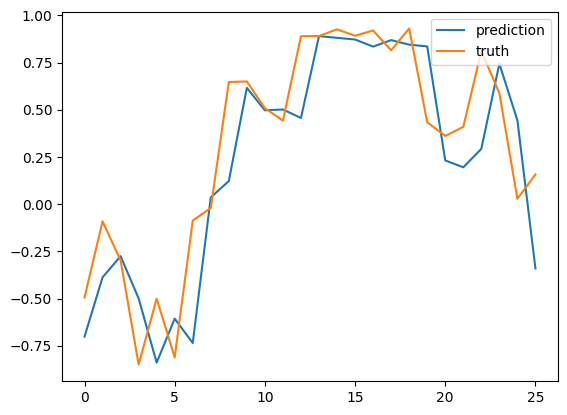

In [ ]:
pyplot.plot(df)
pyplot.legend(['prediction', 'truth'], loc='upper right')
pyplot.show()


In [ ]:
n_period=12
forecast_window = 6
#training dataset

train_y=[]

for i in range(n_period, 544-forecast_window):

    train_y.append(scaled_spei[i+forecast_window - 1])

In [ ]:
train_y = np.array(train_y)
train_y = scalerY.inverse_transform(train_y)

In [ ]:
train_y2 = []

for a in train_y:
  train_y2.append(a[0])

In [ ]:
train_y2 = train_y2[:500]

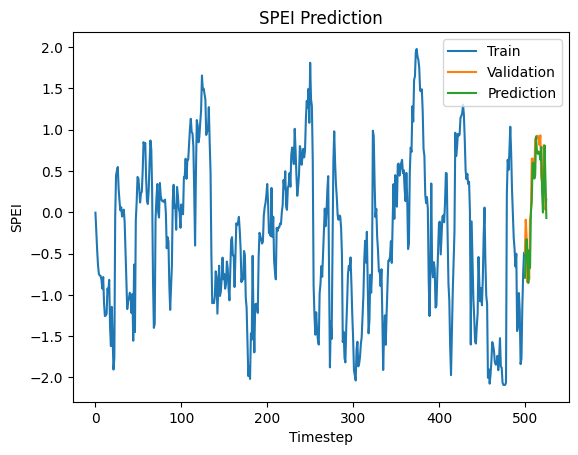

In [ ]:
pyplot.title('SPEI Prediction')
pyplot.xlabel('Timestep')
pyplot.ylabel('SPEI')
pyplot.plot(train_y2, label="Train")
pyplot.plot(range(500, 526), y, label="Truth")
pyplot.plot(range(500, 526), predict, label="Prediction")
pyplot.legend(['Train','Validation', 'Prediction'],loc='upper right')
pyplot.show()

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

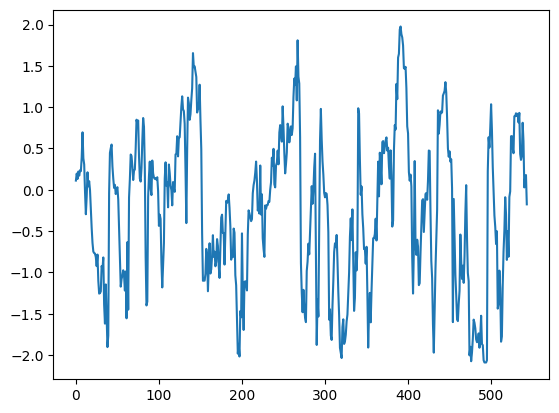

In [ ]:
pyplot.plot(spei_means)

pyplot.show()

In [ ]:
print(testPredict, test_y)

[[0.21474822]
 [0.20911036]
 [0.21208748]
 [0.21729288]
 [0.22407986]
 [0.23008116]
 [0.22957936]
 [0.2332143 ]
 [0.23350574]
 [0.23279558]
 [0.22944634]
 [0.2254352 ]
 [0.22282815]
 [0.2215401 ]
 [0.21892343]
 [0.21584629]
 [0.21377915]
 [0.20579056]
 [0.19641192]
 [0.19038968]] [[0.2700654 ]
 [0.30392263]
 [0.31439315]
 [0.3034853 ]
 [0.30705614]
 [0.31490691]
 [0.32001479]
 [0.28797908]
 [0.29483205]
 [0.31319155]
 [0.30016072]
 [0.27832378]
 [0.25828712]
 [0.27398441]
 [0.24874222]
 [0.28524893]
 [0.31503429]
 [0.28114734]
 [0.29368988]
 [0.28093929]]
